## NLP CHATBOT BERT

In [ ]:
!pip install datasets
!pip install rouge_score
!pip install bert_score

In [4]:
import pandas as pd
import json
import re
from transformers import BertTokenizer, EncoderDecoderModel, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.model_selection import train_test_split
import torch
from rouge_score import rouge_scorer
from bert_score import score

# Function to fix common JSON formatting issues
def fix_json_string(json_str):
    # Ensure the JSON string is correctly formatted
    json_str = re.sub(r'\\', '', json_str)
    json_str = json_str.replace('"', "'")
    json_str = json_str.replace('"', "'")
    json_str = json_str.replace("'from'", '"from"')
    json_str = json_str.replace("'human'", '"human"')
    json_str = json_str.replace("'gpt'", '"gpt"')
    json_str = json_str.replace("'value':", '"value":"')
    json_str = json_str.replace("}", '"},')
    json_str = json_str.replace("},]", '}]')
    json_str = re.sub(r'\\', '', json_str)
    json_str = json_str.replace(": '", ': "')
    json_str = json_str.replace("'}", '"}')
    json_str = json_str.lower()
    json_str = json_str.replace("charlie", '')
    json_str = json_str.replace("alex", '')
    return json_str

# Load data in chunks
def load_conversation_data(df, chunksize=1000):
    conversations = []
    for conv in df['conversations']:
        fixed_conv = fix_json_string(conv)
        try:
            conversations.append(json.loads(fixed_conv))
        except:
            continue
    return conversations

# Function to create conversation history
def create_conversation_history(conversations):
    inputs, targets,only_inputs = [], [],[]
    for conv in conversations:
        temp = []
        for turn in conv:
            if turn.get('from') == 'human':
                only_inputs.append(turn.get('value', ''))
                inputs.append(" ".join(temp) + " " + turn.get('value', ''))
                temp.append(turn.get('value', ''))
            elif turn.get('from') == 'gpt':
                targets.append(turn.get('value', ''))
                temp.append(turn.get('value', ''))
    return inputs, targets, only_inputs


# Load data
df = pd.read_csv('/content/chat_data - Copy.csv')
df = df.dropna()
conversations = load_conversation_data(df)
print("No. of conversations: ",len(conversations))


No. of conversations:  26899


In [5]:
conversations[0]

[{'from': 'human',
  'value': " 'i've been feeling so sad and overwhelmed lately. work has become such a massive source of stress for me.'"},
 {'from': 'gpt',
  'value': " 'hey there, i'm here to listen and support you. it sounds like work has been really challenging lately. can you tell me more about what's been going on?'"},
 {'from': 'human',
  'value': " 'i recently got a promotion at work, which i thought would be exciting. but the added responsibilities and pressure have just taken a toll on my mental health. it's been a really moving experience for me.'"},
 {'from': 'gpt',
  'value': " 'i can understand how it can be overwhelming when we're faced with higher expectations. it's okay to acknowledge your emotions and allow yourself to feel sad in this situation. it's an important part of the healing process. what specific challenges have you been facing at work?'"},
 {'from': 'human',
  'value': " 'well, the workload has increased significantly, and i find it hard to maintain a wor

In [6]:

# Create conversation history
input, target, only_inputs = create_conversation_history([sublist for sublist in conversations])


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


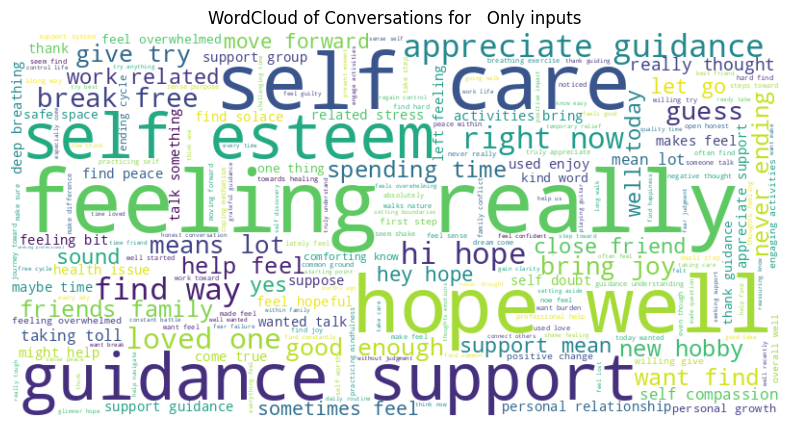

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
# Creating a DataFrame from list of strings
df = pd.DataFrame(only_inputs, columns=["text"])

# Preprocess text: Lowercase, remove stop words, and punctuation
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

df['cleaned_text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

# 1. Word Frequency Analysis
all_words = ' '.join(df['cleaned_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')


plt.title('WordCloud of Conversations for   Only inputs')
plt.show()

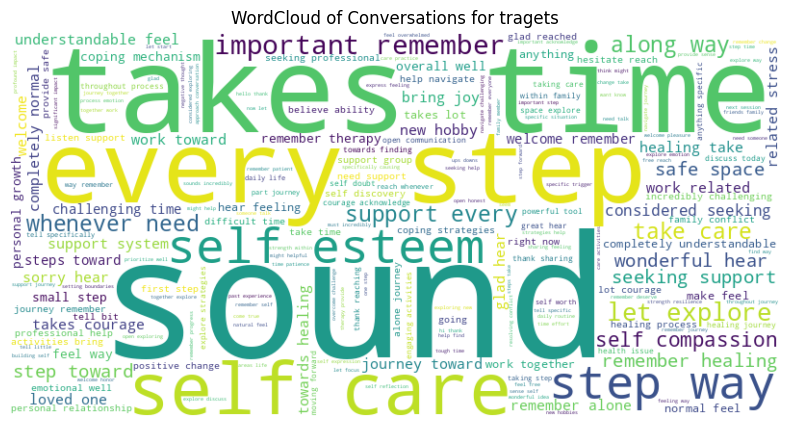

In [ ]:
df = pd.DataFrame(target, columns=["text"])


df['cleaned_text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

# 1. Word Frequency Analysis
all_words = ' '.join(df['cleaned_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud of Conversations for tragets')
plt.show()

In [ ]:
import random

start_index = 0
sample_size = 50000

# Sample 150,000 random indices from the available range
sampled_indices = random.sample(range(start_index, len(input)), sample_size)

# Retrieve the sampled data
inputs = [input[i] for i in sampled_indices]
targets = [target[i] for i in sampled_indices]

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Split data into train and test sets
train_inputs, test_inputs, train_targets, test_targets = train_test_split(only_inputs[:20000], target[:20000], test_size=0.1, random_state=42)

# Create a dataset
train_dataset = Dataset.from_dict({'input_text': train_inputs, 'target_text': train_targets})
test_dataset = Dataset.from_dict({'input_text': test_inputs, 'target_text': test_targets})
print("Train size: ",len(train_dataset))
print("Test size: ",len(test_dataset))

Train size:  18000
Test size:  2000


In [8]:

# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Initialize BERT2BERT model with proper configuration
model = EncoderDecoderModel.from_encoder_decoder_pretrained('bert-base-uncased', 'bert-base-uncased')
model.to(device)
# Set the decoder_start_token_id
model.config.decoder_start_token_id = tokenizer.cls_token_id
model.config.pad_token_id = tokenizer.pad_token_id
model.config.vocab_size = model.config.encoder.vocab_size

# Tokenization function
def tokenize_function(examples):
    model_inputs = tokenizer(examples['input_text'], max_length=128, padding='max_length', truncation=True)
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples['target_text'], max_length=128, padding='max_length', truncation=True)
    model_inputs['labels'] = labels['input_ids']
    return model_inputs

# Tokenize datasets
train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=3e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=5,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_total_limit=2,
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

# Train the model
trainer.train()


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertLMHeadModel were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['bert.encoder.layer.0.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.0.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.0.crossattention.output.dense.bias', 'bert.encoder.layer.0.crossattention.output.dense.weight', 'bert.encoder.layer.0.crossattention.self.key.bias', 'bert.encoder.layer.0.crossattention.self.key.weight', 'bert.encoder.layer.0.crossattention.self.query.bias', 'bert.encoder.layer.0.crossattention.self.query.weight', 'bert.encoder.layer.0.crossattention.self.value.bias', 'bert.encoder.layer.0.crossattention.self.value.weight', 'bert.encoder.layer.1.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.1.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.1.crossattention.output.dense.bias', 'bert.encoder.layer.1.crossattention.output.dense.weight', 'bert.encoder.layer.1.crossattention.self.key.bias', 'bert.e

Map:   0%|          | 0/18000 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:4126: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:623: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  decoder_attention_mask = decoder_input_ids.new_tensor(decoder_input_ids != self.config.pad_token_id)
/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:643: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained 

Epoch,Training Loss,Validation Loss
1,1.495300,0.857916
2,0.837700,0.806680
3,0.757500,0.804704
4,0.706600,0.797983
5,0.675300,0.797613


/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:623: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  decoder_attention_mask = decoder_input_ids.new_tensor(decoder_input_ids != self.config.pad_token_id)
/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:643: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)
/usr/local/lib/python3.10/dist-packages/tra

TrainOutput(global_step=2815, training_loss=0.8688519493089476, metrics={'train_runtime': 5213.662, 'train_samples_per_second': 17.262, 'train_steps_per_second': 0.54, 'total_flos': 1.38027172608e+16, 'train_loss': 0.8688519493089476, 'epoch': 5.0})

In [ ]:

# Evaluate the model
def evaluate_model(model, test_dataset, tokenizer):
    model.eval()  # Set the model to evaluation mode

    all_predictions = []
    all_labels = []

    # Process the dataset in batches
    for i in range(0, len(test_dataset), 16):  # Batch size of 16
        batch = test_dataset[i:i+16]

        input_ids = torch.tensor(batch['input_ids']).to(model.device)
        attention_mask = torch.tensor(batch['attention_mask']).to(model.device)

        with torch.no_grad():
            outputs = model.generate(
                input_ids=input_ids,
                attention_mask=attention_mask,
                max_length=128,
                num_return_sequences=1,
                decoder_start_token_id=model.config.decoder_start_token_id,
                bos_token_id=model.config.bos_token_id,
                eos_token_id=model.config.eos_token_id,
                pad_token_id=model.config.pad_token_id,
            )

        # Decode predictions
        decoded_preds = tokenizer.batch_decode(outputs, skip_special_tokens=True)
        all_predictions.extend(decoded_preds)

        # Decode labels
        decoded_labels = tokenizer.batch_decode(batch['labels'], skip_special_tokens=True)
        all_labels.extend(decoded_labels)

    # ROUGE-L Score
    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    rouge_scores = [scorer.score(pred, label)['rougeL'].fmeasure for pred, label in zip(all_predictions, all_labels)]
    avg_rouge_l = sum(rouge_scores) / len(rouge_scores)

    # BERT Score
    P, R, F1 = score(all_predictions, all_labels, lang='en', verbose=True)
    avg_bert_score = F1.mean().item()

    return avg_rouge_l, avg_bert_score

# Evaluate the model
rouge_l, bert_score = evaluate_model(model, test_dataset, tokenizer)
print(f"ROUGE-L Score: {rouge_l}")
print(f"BERT Score: {bert_score}")

# Chat with the model
def chat_with_model(input_text, model, tokenizer):
    model.eval()
    inputs = tokenizer(input_text, return_tensors='pt', padding=True, truncation=True)
    input_ids = inputs['input_ids'].to(model.device)
    attention_mask = inputs['attention_mask'].to(model.device)

    with torch.no_grad():
        outputs = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_length=128,
            num_return_sequences=1,
            decoder_start_token_id=model.config.decoder_start_token_id,
            bos_token_id=model.config.bos_token_id,
            eos_token_id=model.config.eos_token_id,
            pad_token_id=model.config.pad_token_id,
        )

    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    temp =   input_text + ' ' + response
    return response, temp

# Interactive loop to chat with the model
print("Start chatting with the model! Type 'exit' to end the conversation.")

while True:
    user_input = input("You: ")
    try:
      user_input= temp + ' ' +  user_input
    except:
      pass
    if user_input.lower() == 'exit':
        break

    response, temp = chat_with_model(user_input, model, tokenizer)
    print(f"Model: {response}")


In [ ]:
import torch

# Save the model state_dict
torch.save(model.state_dict(), "model_state_dict.pth")

# Save the tokenizer using save_pretrained method
tokenizer.save_pretrained("tokenizer_directory")
